In [1]:
from pathlib import Path
path_folder = Path("/Users/keithlowton/Desktop/Ks/Jobs/Coop")
print(path_folder.exists())
print(path_folder)

True
/Users/keithlowton/Desktop/Ks/Jobs/Coop


In [2]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pyvis.network import Network
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import iplot

### Functions

In [3]:
def list_perc(list1, list2):
    return sum(x in list1 for x in list2) / len(list1) * 100


In [ ]:
def create_edgelist_df(df, mergevar, itemvar):
    # Self-join to create pairs of Pokemon and count common habitats
    common_habitats_edges = (
        df.merge(df, on=mergevar, suffixes=("_1", "_2"))            # Self-join
        .query(str(str(itemvar) + "_1 != " + str(itemvar) + "_2"))  # Exclude pairs of the same
        .groupby([str(itemvar) + "_1", str(itemvar) + "_2"])
        .size()
        .reset_index(name="num_of_connections")                     # Count unique conenctions
    )

    # Rename columns
    common_habitats_edges.columns = [str(itemvar) + "_1", str(itemvar) + "_2", "num_of_connections"]

    # Drop Duplicates
    common_habitats_edges["pair"] = common_habitats_edges.apply(
        lambda row: tuple(sorted([row[str(itemvar) + "_1"], row[str(itemvar) + "_2"]])), axis=1
    )
    common_habitats_edges = common_habitats_edges.drop_duplicates(subset="pair").drop(columns="pair")
    common_habitats_edges = common_habitats_edges.reset_index(drop=True)

    return common_habitats_edges

### Read the data in

In [4]:
data = pd.read_csv(os.path.join(path_folder, "test_case.csv"))
print(data.shape)
# (1115234, 45)
data.head()

/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_12688/1949382399.py:1: DtypeWarning: Columns (30,33,35,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(path_folder, "test_case.csv"))


(1115234, 45)


Unnamed: 0                               receiptLineNumberKey  \
0           0  e0a19bdccd8bafe5cad3b0ea9c4c1e6725895b944cb9cf...   
1           1  1363f3fdee49e80944c31cc6cfed9955102a92c0c1b886...   
2           2  672efa006e293107b15c4ba323a92aefc14bf41bce8a61...   
3           3  b4ed8f934f0aea65d401d9db542fcbbe33ec72e51eba2c...   
4           4  b3d2d7aa8b91aa728ce18f1d23ba33ceb1270a0082b6f9...   

                                          receiptKey  quantity  \
0  51765ae8bccae31a15062407ee61ce789a321363454401...     0.012   
1  51765ae8bccae31a15062407ee61ce789a321363454401...     1.000   
2  51765ae8bccae31a15062407ee61ce789a321363454401...     1.000   
3  51765ae8bccae31a15062407ee61ce789a321363454401...     0.049   
4  51765ae8bccae31a15062407ee61ce789a321363454401...     0.005   

   salesUnitPrice  regularUnitPrice  costUnitPrice  \
0          -96.67             -1.16           7.50   
1           20.00              5.10          17.47   
2            5.00             -0.95           5.30   
3           -4.90             -4.90           0.00   
4          -98.00             -0.49           2.00   

                                              ItemID  \
0  9b37e0d1b451cda9904e6d37029169e13873744fa7bda8...   
1  7e793524babd1941b13dfb8b33d698ed72f815d1fd81cb...   
2  2f70551ade256131f1d0dcc09a32eed86575fa468f9106...   
3  73a1c416e840593337011d27480fd3e642aa8457198a6e...   
4  08bf92e08f864bca123ca2bba6963e7e863e7c89deb579...   

        ItemSubCategory_subSegmentName  ItemCategoryID  ... MosaicType  \
0  LÄSK DRICKA SEDAN SINGEL 100-200 CL             249  ...        L34   
1                   DRUVOR RÖDA DRUVOR             231  ...        L34   
2     SPECIELLA TILLFÄLLEN SOCKERGODIS             224  ...        L34   
3                     CITRUS APELSINER             231  ...        L34   
4       KONCENTRAT FRUKTIGA KONCENTRAT             216  ...        L34   

        MosaicTypeDescription DominantBuyingPowerClass  customerType  \
0  L34 Sudoku och sparkapital        Medelhog_kopkraft             P   
1  L34 Sudoku och sparkapital        Medelhog_kopkraft             P   
2  L34 Sudoku och sparkapital        Medelhog_kopkraft             P   
3  L34 Sudoku och sparkapital        Medelhog_kopkraft             P   
4  L34 Sudoku och sparkapital        Medelhog_kopkraft             P   

  genderCode                                           storeKey conceptId  \
0          F  ed26534384eb017884532a37263739552fa9531aba94b8...        46   
1          F  ed26534384eb017884532a37263739552fa9531aba94b8...        46   
2          F  ed26534384eb017884532a37263739552fa9531aba94b8...        46   
3          F  ed26534384eb017884532a37263739552fa9531aba94b8...        46   
4          F  ed26534384eb017884532a37263739552fa9531aba94b8...        46   

   conceptCategoryID YearMonthDay  hourOfDay  
0                  1     20190118         11  
1                  1     20190118         11  
2                  1     20190118         11  
3                  1     20190118         11  
4                  1     20190118         11  

[5 rows x 45 columns]

In [5]:
data.duplicated().sum()

0

In [6]:
nonvar_lst = []

for i in range(data.shape[1]):
    print("Column: ", data.columns[i], ", number of unique classes: ", data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print("Values: ", list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])

print(nonvar_lst)

Column:  Unnamed: 0 , number of unique classes:  1115234
Column:  receiptLineNumberKey , number of unique classes:  1115234
Column:  receiptKey , number of unique classes:  121745
Column:  quantity , number of unique classes:  3161
Column:  salesUnitPrice , number of unique classes:  17695
Column:  regularUnitPrice , number of unique classes:  18648
Column:  costUnitPrice , number of unique classes:  12424
Column:  ItemID , number of unique classes:  14827
Column:  ItemSubCategory_subSegmentName , number of unique classes:  2307
Column:  ItemCategoryID , number of unique classes:  139
Column:  ItemCategoryName , number of unique classes:  139
Column:  ItemSubCategoryID , number of unique classes:  43
Values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 9999, 9998, 15, 17, 19, 20, 21, 22, 23, 24, 16, 26, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 50, 55, 2430, 99, -1]
Column:  ItemSubCategoryName , number of unique classes:  506
Column:  ItemSegmentID , number of unique classes

In [7]:
data.drop(nonvar_lst, axis=1, inplace=True)

### Missing values

In [8]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ["Count"]
check["perc"] = check.Count/data.shape[0]*100
check

Count       perc
Unnamed: 0                           0   0.000000
receiptLineNumberKey                 0   0.000000
receiptKey                           0   0.000000
quantity                             0   0.000000
salesUnitPrice                       0   0.000000
regularUnitPrice                     0   0.000000
costUnitPrice                        0   0.000000
ItemID                               0   0.000000
ItemSubCategory_subSegmentName       0   0.000000
ItemCategoryID                       0   0.000000
ItemCategoryName                     0   0.000000
ItemSubCategoryID                    0   0.000000
ItemSubCategoryName                  0   0.000000
ItemSegmentID                        0   0.000000
ItemSegmentName                      0   0.000000
ItemSubSegmentID                     0   0.000000
ItemSubSegmentName                   0   0.000000
ItemCategoryTeamID                   0   0.000000
ItemCategoryTeamName                 0   0.000000
ItemCategoryGroupID                  0   0.000000
ItemCategoryGroupName                0   0.000000
ItemCategoryAreaID                   0   0.000000
ItemCategoryAreaName                 0   0.000000
ItemSubSegmentHierarchy              0   0.000000
ItemSegmentHierarchy                 0   0.000000
ItemSubCategoryHierarchy             0   0.000000
ItemCategoryHierarchy                0   0.000000
ItemCategoryTeamHierarchy            0   0.000000
ItemCategoryGroupHierarchy           0   0.000000
ItemCategoryAreaHierarchy            0   0.000000
MM_CustomerID                        0   0.000000
householdKey                         0   0.000000
MosaicKey                            0   0.000000
MosaicGroup                          0   0.000000
MosaicGroupDescription               0   0.000000
MosaicType                           0   0.000000
MosaicTypeDescription                0   0.000000
DominantBuyingPowerClass             0   0.000000
customerType                    490992  44.025917
genderCode                      490992  44.025917
storeKey                             0   0.000000
conceptId                            0   0.000000
YearMonthDay                         0   0.000000
hourOfDay                            0   0.000000

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115234 entries, 0 to 1115233
Data columns (total 44 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Unnamed: 0                      1115234 non-null  int64  
 1   receiptLineNumberKey            1115234 non-null  object 
 2   receiptKey                      1115234 non-null  object 
 3   quantity                        1115234 non-null  float64
 4   salesUnitPrice                  1115234 non-null  float64
 5   regularUnitPrice                1115234 non-null  float64
 6   costUnitPrice                   1115234 non-null  float64
 7   ItemID                          1115234 non-null  object 
 8   ItemSubCategory_subSegmentName  1115234 non-null  object 
 9   ItemCategoryID                  1115234 non-null  int64  
 10  ItemCategoryName                1115234 non-null  object 
 11  ItemSubCategoryID               1115234 non-null  int64  
 12  

In [10]:
item_cols = [col for col in data.columns if ("Item" in col)]
print("Item columns:", item_cols)
value_cols = ["quantity", "salesUnitPrice", "receiptKey", "regularUnitPrice", "costUnitPrice", "receiptLineNumberKey"]
print("Value columns:", value_cols)
time_cols = ["YearMonthDay", "hourOfDay"]
print("Time columns:", time_cols)
other_cols = list(set(list(data.columns)) - set(item_cols + value_cols + time_cols))
print("Other columns:", other_cols)

Item columns: ['ItemID', 'ItemSubCategory_subSegmentName', 'ItemCategoryID', 'ItemCategoryName', 'ItemSubCategoryID', 'ItemSubCategoryName', 'ItemSegmentID', 'ItemSegmentName', 'ItemSubSegmentID', 'ItemSubSegmentName', 'ItemCategoryTeamID', 'ItemCategoryTeamName', 'ItemCategoryGroupID', 'ItemCategoryGroupName', 'ItemCategoryAreaID', 'ItemCategoryAreaName', 'ItemSubSegmentHierarchy', 'ItemSegmentHierarchy', 'ItemSubCategoryHierarchy', 'ItemCategoryHierarchy', 'ItemCategoryTeamHierarchy', 'ItemCategoryGroupHierarchy', 'ItemCategoryAreaHierarchy']
Value columns: ['quantity', 'salesUnitPrice', 'receiptKey', 'regularUnitPrice', 'costUnitPrice', 'receiptLineNumberKey']
Time columns: ['YearMonthDay', 'hourOfDay']
Other columns: ['Unnamed: 0', 'MosaicType', 'conceptId', 'householdKey', 'MM_CustomerID', 'storeKey', 'genderCode', 'MosaicGroupDescription', 'MosaicTypeDescription', 'customerType', 'DominantBuyingPowerClass', 'MosaicGroup', 'MosaicKey']


In [11]:
for name in item_cols:
    print("Column: ", name, ", number of unique classes: ", data[name].nunique())
    if data[name].nunique() < 50:
        print("Values: ", data[name].unique())

Column:  ItemID , number of unique classes:  14827
Column:  ItemSubCategory_subSegmentName , number of unique classes:  2307
Column:  ItemCategoryID , number of unique classes:  139
Column:  ItemCategoryName , number of unique classes:  139
Column:  ItemSubCategoryID , number of unique classes:  43
Values:  [   1   33    7   32    3   23    2   13   14   30   31   38    5   36
   11    4   40    9   -1   10   37   22    8   35   39 9999   21   99
    6   12   34   50 9998   24   20   15   41 2430   17   55   26   19
   16]
Column:  ItemSubCategoryName , number of unique classes:  506
Column:  ItemSegmentID , number of unique classes:  55
Column:  ItemSegmentName , number of unique classes:  1301
Column:  ItemSubSegmentID , number of unique classes:  54
Column:  ItemSubSegmentName , number of unique classes:  1872
Column:  ItemCategoryTeamID , number of unique classes:  24
Values:  [423410 423240 423320 423250 423440 423310 423220 423225     -1 423520
 432220 434110 423210 432340 432910

### Clean the data

In [54]:
df = data.copy()

df = df[(~df.ItemCategoryName.isin(["IN&UTBETAL MOMSF"])) & (df['MM_CustomerID'].str.startswith('-1') == False)]

for name in ["customerType", "genderCode"]:
    df[name] = df[name].fillna("Missing")

df["Date"] = pd.to_datetime(df.YearMonthDay, format="%Y%m%d")
df["Weekday_name"] = df["Date"].dt.day_name()

df["Total"] = df["quantity"] * df["regularUnitPrice"]

hier_cols = [col for col in df.columns if ("Hierarchy" in col)]

df["discount"] = 0
df.loc[(df["quantity"] < 0), "discount"] = 1

df["quantity"] = df["quantity"].abs()
df["regularUnitPrice"] = df["regularUnitPrice"].abs()

df.drop(["ItemCategoryTeamHierarchy", "ItemCategoryGroupHierarchy", "ItemCategoryAreaHierarchy",
         "ItemSegmentID", "ItemSubSegmentID", "ItemCategoryTeamID", "ItemCategoryAreaID",
         "Unnamed: 0", "ItemCategoryID", "ItemSubCategoryID", "ItemCategoryGroupID"] + hier_cols, axis=1, inplace=True)

In [55]:
item_cols = [col for col in df.columns if ("Item" in col)]

In [56]:
df[item_cols].head()

ItemID  \
0  9b37e0d1b451cda9904e6d37029169e13873744fa7bda8...   
1  7e793524babd1941b13dfb8b33d698ed72f815d1fd81cb...   
2  2f70551ade256131f1d0dcc09a32eed86575fa468f9106...   
3  73a1c416e840593337011d27480fd3e642aa8457198a6e...   
4  08bf92e08f864bca123ca2bba6963e7e863e7c89deb579...   

        ItemSubCategory_subSegmentName  ItemCategoryName  \
0  LÄSK DRICKA SEDAN SINGEL 100-200 CL         LÄSK&SAFT   
1                   DRUVOR RÖDA DRUVOR       FRUKT & BÄR   
2     SPECIELLA TILLFÄLLEN SOCKERGODIS             GODIS   
3                     CITRUS APELSINER       FRUKT & BÄR   
4       KONCENTRAT FRUKTIGA KONCENTRAT  OKYLD JUICE&FRUK   

    ItemSubCategoryName       ItemSegmentName   ItemSubSegmentName  \
0     LÄSK DRICKA SEDAN       MAINSTREAM MUST    SINGEL 100-200 CL   
1                DRUVOR           RÖDA DRUVOR          RÖDA DRUVOR   
2  SPECIELLA TILLFÄLLEN                   JUL          SOCKERGODIS   
3                CITRUS             APELSINER            APELSINER   
4            KONCENTRAT  FRUKTDRYCKSKONCENTRA  FRUKTIGA KONCENTRAT   

    ItemCategoryTeamName ItemCategoryGroupName ItemCategoryAreaName  
0               Kolonial           Torra varor                 Food  
1  Frukt Grönt & Blommor           Frukt Grönt                 Food  
2  Godis, Snacks o Kiosk           Torra varor                 Food  
3  Frukt Grönt & Blommor           Frukt Grönt                 Food  
4       Mejeri, Ost, Ägg          Färska varor                 Food

In [54]:
df[item_cols].describe(include="all")

ItemID ItemCategoryName  \
count                                             1114706          1114706   
unique                                              14821              138   
top     2c410323625dccf6ca832650ddb5a2a650f523d19b14cf...        GRÖNSAKER   
freq                                                24821           106172   

       ItemSubCategoryName ItemCategoryTeamName ItemCategoryGroupName  \
count              1114706              1114706               1114706   
unique                 505                   24                    12   
top             PANTER-ÖVR             Kolonial           Torra varor   
freq                 48553               224498                454268   

       ItemCategoryAreaName  
count               1114706  
unique                    8  
top                    Food  
freq                1029127

In [55]:
df[value_cols].head()

quantity  salesUnitPrice  \
0     0.012          -96.67   
1     1.000           20.00   
2     1.000            5.00   
3     0.049           -4.90   
4     0.005          -98.00   

                                          receiptKey  regularUnitPrice  \
0  51765ae8bccae31a15062407ee61ce789a321363454401...              1.16   
1  51765ae8bccae31a15062407ee61ce789a321363454401...              5.10   
2  51765ae8bccae31a15062407ee61ce789a321363454401...              0.95   
3  51765ae8bccae31a15062407ee61ce789a321363454401...              4.90   
4  51765ae8bccae31a15062407ee61ce789a321363454401...              0.49   

   costUnitPrice                               receiptLineNumberKey  
0           7.50  e0a19bdccd8bafe5cad3b0ea9c4c1e6725895b944cb9cf...  
1          17.47  1363f3fdee49e80944c31cc6cfed9955102a92c0c1b886...  
2           5.30  672efa006e293107b15c4ba323a92aefc14bf41bce8a61...  
3           0.00  b4ed8f934f0aea65d401d9db542fcbbe33ec72e51eba2c...  
4           2.00  b3d2d7aa8b91aa728ce18f1d23ba33ceb1270a0082b6f9...

### Most popular

In [67]:
quant_vals = df.groupby(["ItemCategoryName"])["quantity"].sum().to_frame("quantity").reset_index()
quant_vals = quant_vals.sort_values(["quantity"], ascending=False)
quant_vals = quant_vals[:10]

fig = px.bar(
    quant_vals,
    x="ItemCategoryName",
    y="quantity",
    hover_data=["quantity"],
    color="quantity",
    labels={"quantity": "Quantity", "ItemCategoryName":"Item Category Name"},
    height=400,
)
fig.show()


In [108]:
price_vals = df.groupby(["ItemCategoryName"])["regularUnitPrice"].sum().to_frame("regularUnitPrice").reset_index()
price_vals = price_vals.sort_values(["regularUnitPrice"], ascending=False)
price_vals_100 = price_vals[:100]
price_vals = price_vals[:10]

fig = px.bar(
    price_vals,
    x="ItemCategoryName",
    y="regularUnitPrice",
    hover_data=["regularUnitPrice"],
    color="regularUnitPrice",
    labels={"regularUnitPrice": "Sales", "ItemCategoryName":"Item Category Name"},
    height=400,
)
fig.show()


In [71]:
quant_time_df = df[df.ItemCategoryName.isin(list(quant_vals.ItemCategoryName))]
quant_time_df = quant_time_df.groupby(["ItemCategoryName", "Date"])["quantity"].sum().reset_index()

fig = px.line(
    quant_time_df,
    x="Date",
    y="quantity",
    color="ItemCategoryName",
    labels={"quantity": "Quantity", "ItemCategoryName": "Item Category Name"},
)
fig.show()


In [69]:
quant_time_df

### Loyalty

In [84]:
cust_list = (
    df.groupby(["MM_CustomerID"])["ItemSubCategory_subSegmentName"].unique().to_frame("Customer_list").reset_index()
)

receipt_list = (
    df.groupby(["MM_CustomerID", "receiptKey"])["ItemSubCategory_subSegmentName"]
    .unique()
    .to_frame("Receipt_list")
    .reset_index()
)

item_count = (
    df.groupby(["MM_CustomerID", "receiptKey"])["ItemSubCategory_subSegmentName"]
    .nunique()
    .to_frame("Item_count")
    .reset_index()
)

list_all = pd.merge(cust_list, receipt_list, on=["MM_CustomerID"])
list_all = pd.merge(list_all, item_count, on=["MM_CustomerID", "receiptKey"], how="left")

list_all["list_perc"] = list_all.apply(lambda x: list_perc(x.Customer_list, x.Receipt_list), axis=1)
list_all.head()


MM_CustomerID  \
0  00001f9f41b8b4ffc64da41b01c81b6c212c55dbd0d63a...   
1  00001f9f41b8b4ffc64da41b01c81b6c212c55dbd0d63a...   
2  00001f9f41b8b4ffc64da41b01c81b6c212c55dbd0d63a...   
3  00001f9f41b8b4ffc64da41b01c81b6c212c55dbd0d63a...   
4  00001f9f41b8b4ffc64da41b01c81b6c212c55dbd0d63a...   

                                       Customer_list  \
0  [PÅLÄGGSOST HUSHÅLLSOST MILD/MEL, ÄPPLEN ÄPPLE...   
1  [PÅLÄGGSOST HUSHÅLLSOST MILD/MEL, ÄPPLEN ÄPPLE...   
2  [PÅLÄGGSOST HUSHÅLLSOST MILD/MEL, ÄPPLEN ÄPPLE...   
3  [PÅLÄGGSOST HUSHÅLLSOST MILD/MEL, ÄPPLEN ÄPPLE...   
4  [PÅLÄGGSOST HUSHÅLLSOST MILD/MEL, ÄPPLEN ÄPPLE...   

                                          receiptKey  \
0  20975876cca54fa35d4f577944b6fc13790a255e75c784...   
1  379322e5cde08cd6c680e160b7c91414912683c16a3ed4...   
2  47fdee850bbde9537881e8a881b40e51715e045830a217...   
3  57e23465b387cba89d402476924ca427847e9437c3d964...   
4  62bad0fd4c92b4debf3c6354559fa3520d07327e2ceea0...   

                                        Receipt_list  Item_count  list_perc  
0  [MÅLTIDSLÖSNING TRADITIONELL MÅLTIDS, ÖVRIG MA...           8  13.793103  
1  [ÄPPLEN ÄPPLEN RÖDA, SALLADSGRÖNSAKER GURKA, R...           8  13.793103  
2  [PÅLÄGGSOST HUSHÅLLSOST MILD/MEL, KOSTTILLSKOT...          12  20.689655  
3  [SPECIELLA TILLFÄLLEN CHOKLAD, POTATIS LÖSVIKT...           3   5.172414  
4  [CITRUS APELSINER, SPECIELLA TILLFÄLLEN ASK 40...           6  10.344828

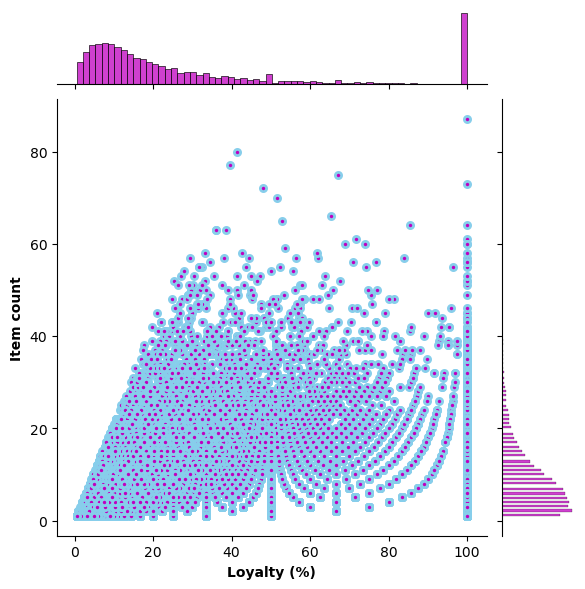

In [85]:
ax = sns.jointplot(x=list_all["list_perc"],
                   y=list_all["Item_count"],
                   kind="scatter",
                   s=20,
                   color="m",
                   edgecolor="skyblue",
                   linewidth=2)
ax.ax_joint.set_xlabel("Loyalty (%)", fontweight="bold")
ax.ax_joint.set_ylabel("Item count", fontweight="bold")
plt.show()

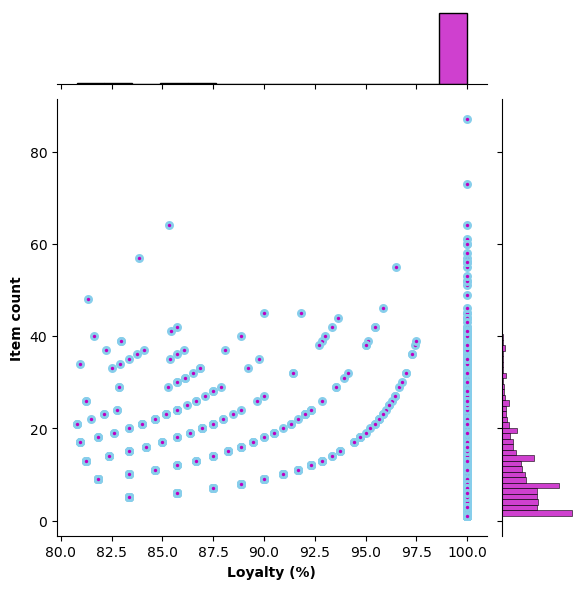

In [86]:
list_all_c = list_all[list_all["list_perc"] > 80]
ax = sns.jointplot(x=list_all_c["list_perc"],
                   y=list_all_c["Item_count"],
                   kind="scatter",
                   s=20,
                   color="m",
                   edgecolor="skyblue",
                   linewidth=2)
ax.ax_joint.set_xlabel("Loyalty (%)", fontweight="bold")
ax.ax_joint.set_ylabel("Item count", fontweight="bold")
plt.show()

### Network analysis

In [141]:
nx_df = df[df.Date == "2019-01-18"]
nx_df = nx_df[nx_df.ItemSubCategoryName.isin(list(nx_df.ItemSubCategoryName.value_counts().index)[:20])]
nx_df = nx_df[["receiptKey", "ItemSubCategoryName"]].drop_duplicates()
print(nx_df.shape)

(4073, 2)


In [150]:
edgelist = create_edgelist_df(nx_df, "receiptKey", "ItemSubCategoryName")
edgelist = edgelist[edgelist.num_of_connections > np.mean(edgelist.num_of_connections)]
print(edgelist.shape)
edgelist.head()

(82, 3)


ItemSubCategoryName_1 ItemSubCategoryName_2  num_of_connections
0                     0               BANANER                  80
1                     0          CHIPS&SNACKS                  90
2                     0               CHOKLAD                  75
3                     0                CITRUS                 109
5                     0     FRUKOST&MELLANMÅL                  86

In [188]:
nodelist = set(list(edgelist.ItemSubCategoryName_1.unique()) + list(edgelist.ItemSubCategoryName_2.unique()))
nodelist = list(nodelist)
print(len(nodelist))

20


In [222]:
size_dict = dict()
for val in nodelist:
    dset = edgelist[(edgelist.ItemSubCategoryName_1 == val) | (edgelist.ItemSubCategoryName_2 == val)]
    size_dict[val] = np.mean(dset.num_of_connections)


In [153]:
G = nx.Graph()

for i in nodelist:
    G.add_node(i)

for i, j in edgelist.iterrows():
    G.add_edges_from([(j["ItemSubCategoryName_1"], j["ItemSubCategoryName_2"])], weight=j["num_of_connections"])

In [263]:
pos = nx.spring_layout(G, k=0.5, iterations=50)

for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(x=[], y=[], line=dict(width=0.1, color="#888"), hoverinfo="none", mode="lines")

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]["pos"]
    x1, y1 = G.nodes[edge[1]]["pos"]
    edge_trace["x"] += tuple([x0, x1, None])
    edge_trace["y"] += tuple([y0, y1, None])
    edge_trace.line = dict(width=int(
                                edgelist.loc[
                                    ((edgelist.ItemSubCategoryName_1 == edge[0]) | (edgelist.ItemSubCategoryName_2 == edge[0]))
                                    & ((edgelist.ItemSubCategoryName_1 == edge[1]) | (edgelist.ItemSubCategoryName_2 == edge[1])),
                                    "num_of_connections",
                                ]
                            ) / 40, color="#888")


node_sizes = []

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[str(node) for node in G.nodes()],
    mode="markers+text",
    hoverinfo="text",
    marker=dict(
        showscale=True,
        colorscale="RdBu",
        reversescale=True,
        color=[],
        size=[],
        colorbar=dict(thickness=10, title="Node Connections", xanchor="left", titleside="right"),
        line=dict(width=0),
    ),
)

for node in G.nodes():
    x, y = G.nodes[node]["pos"]
    node_trace["x"] += tuple([x])
    node_trace["y"] += tuple([y])
    size = size_dict[node] / 5
    node_sizes.append(size)


In [264]:
degree_dict = dict(G.degree)
clustering_dict = nx.clustering(G)
betweenness_dict = nx.betweenness_centrality(G)
degree_val_dict = {}
for node_val in list(set((list(edgelist.ItemSubCategoryName_1.unique()) + list(edgelist.ItemSubCategoryName_2.unique())))):
    degree_val_dict[node_val] = list(set(
        list(edgelist[edgelist.ItemSubCategoryName_1 == node_val].ItemSubCategoryName_2.unique()) +
        list(edgelist[edgelist.ItemSubCategoryName_2 == node_val].ItemSubCategoryName_1.unique())
    ))


node_adjacencies = []
node_hovertext = []
for node in G.nodes():
    degree = degree_dict[node]
    clustering = clustering_dict[node]
    betweenness = betweenness_dict[node]
    connected = degree_val_dict[node]
    hover_text = (
        f"Node: {node}<br>"
        f"Degree: {degree}<br>"
        f"Clustering coefficient: {clustering:.2f}<br>"
        f"Betweenness centrality: {betweenness:.2f}<br>"
        f"Connections: {connected}<br>"
    )
    node_adjacencies.append(degree)
    node_hovertext.append(hover_text)

    node_trace.marker.color = node_adjacencies
    node_trace.hovertext = node_hovertext
    node_trace.marker.size = node_sizes

In [265]:
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="<br> Connections",
        titlefont=dict(size=16),
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        #annotations=[dict(text="No. of connections", showarrow=False, xref="paper", yref="paper")],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)

iplot(fig)


In [134]:
fig = px.bar(
    x=degree_dict.keys(),
    y=degree_dict.values(),
    hover_data=[degree_dict.values()],
    color=degree_dict.values(),
    labels={"x": "Item Sub Category Name", "y":"Degree", "hover_data":"Degree"},
    height=400,
)
fig.show()

In [186]:
fig = px.bar(
    x=clustering_dict.keys(),
    y=clustering_dict.values(),
    hover_data=[clustering_dict.values()],
    color=clustering_dict.values(),
    labels={"x": "Item Sub Category Name", "y":"Clustering", "hover_data":"Clustering"},
    height=400,
)
fig.show()

In [187]:
fig = px.bar(
    x=betweenness_dict.keys(),
    y=betweenness_dict.values(),
    hover_data=[betweenness_dict.values()],
    color=betweenness_dict.values(),
    labels={"x": "Item Sub Category Name", "y":"Betweenness", "hover_data":"Betweenness"},
    height=400,
)
fig.show()